In [1]:
import os 
os.chdir("..")


In [16]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
mode = "damping"
dtt = 1e-4
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params(pars)

total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt, total_time=8)
times = np.arange(0, total_time+ dt, dt)

In [28]:

def load_liks(itrajj, mode="damping", dtt=1e-4, total_time=8.):
    pars = give_def_params_discrimination(flip=0, mode = mode, )
    params, exp_path = check_params(pars)

    total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt, total_time = total_time)
    
    logliks =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    l0,l1 = logliks[:,0], logliks[:,1]
    log_lik_ratio = l1 - l0  ###

    pars = give_def_params_discrimination(flip=1, mode=mode)
    params, exp_path = check_params(pars)
    total_time, dt = get_total_time_dt(params, ppp=1000,dt=dtt ,total_time = total_time)
    logliks_swap =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    log_lik_ratio_swap = logliks_swap[:,0] - logliks_swap[:,1]  
    
    return log_lik_ratio, log_lik_ratio_swap

In [247]:
indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

def get_stop_time(ell,b):
    ind_times = np.argmin(np.logical_and(ell <= b, ell >= -b))
    if ind_times !=0:
        return times[ind_times]
    else:
        return np.nan

In [264]:
boundsB = np.arange(0,5,1.)

deter, stoch = {}, {}
deter["h0/h1"]  = {k:[] for k in range(len(boundsB))}
deter["h1/h0"] = {k:[] for k in range(len(boundsB))}


Ntrajs=5000

stop = {}
stop["_0"] = {i:[] for i in range(1,Ntrajs)}
stop["_1"] = {i:[] for i in range(1,Ntrajs)}


mode="damping"
dtt=1e-4
total_time=8.

itraj = 1
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode=mode, dtt=dtt, total_time=total_time)


l_1 = log_lik_ratio
l_0 = log_lik_ratio_swap

for time_index in tqdm(indis):
    for indb, b in enumerate(boundsB):
        deter_1 = log_lik_ratio[time_index] <= b
        deter_0 = log_lik_ratio_swap[time_index] >= b
        deter["h0/h1"][indb].append(int(deter_1))
        deter["h1/h0"][indb].append(int(deter_0))
        
for b in boundsB:
    stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b))
    stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
n=1


for itraj in tqdm(range(2,Ntrajs)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
    log_lik_ratio = log_lik_ratio[:indfin]
    log_lik_ratio_swap = log_lik_ratio_swap[:indfin]

    ll += log_lik_ratio
    ll0+= log_lik_ratio_swap
    n+=1
    for ind, time_index in enumerate(indis):
        for indb, b in enumerate(boundsB):
            deter_1 = log_lik_ratio[time_index] <= b
            deter_0 = log_lik_ratio_swap[time_index] >= b

            deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
            deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n

    for b in boundsB:
        stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b))
        stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
    

100%|██████████| 4998/4998 [26:35<00:00,  3.13it/s]  


In [265]:
stop1 = np.stack(stop["_1"].values())

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [268]:
mmeans = np.mean(stop1,axis=0)

In [269]:
sstd = np.std(stop1,axis=0)

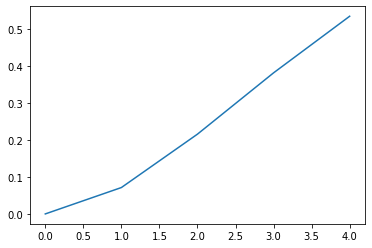

In [270]:
plt.plot(mmeans)


In [292]:
stop0 = np.stack(stop["_0"].values())
stop1 = np.stack(stop["_1"].values())

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [277]:
### compute stopping time

stopps1 = [np.array(stop["_1"][k])[~np.isnan(stop["_1"][k])] for k in stop["_1"].keys()]
stopps0 = [np.array(stop["_0"][k])[~np.isnan(stop["_0"][k])] for k in stop["_0"].keys()]

ind_max_traj1 = np.argmax([len(k) for k in stopps1])
ind_max_traj0 = np.argmax([len(k) for k in stopps0])

stop_time1 = stopps1[ind_max_traj1]
stop_time1_sq = stopps1[ind_max_traj1]**2
ns1 = 2*np.ones(len(stopps1[ind_max_traj1]))

stop_time0 = stopps0[ind_max_traj0]
stop_time0_sq = stopps0[ind_max_traj1]**2
ns0 = 2*np.ones(len(stopps0[ind_max_traj0]))

itrajs1 = list(range(1,Ntrajs))
itrajs0 = list(range(1,Ntrajs))
itrajs1.remove(ind_max_traj1+1)
itrajs0.remove(ind_max_traj0+1)

for i in tqdm(itrajs1):
    for ind,b in enumerate(boundsB[:len(stopps1[ind_max_traj1])]):
        try: 
            stop_time1[ind] += (stopps1[i][ind] - stop_time1[ind])/ns1[ind]
            stop_time1_sq[ind] += (stopps1[i][ind]**2 - stop_time1_sq[ind])/ns1[ind]
            
            ns1[ind] +=1
        except Exception:
            pass
        
for i in tqdm(itrajs0):
    for ind,b in enumerate(boundsB[:len(stopps0[ind_max_traj0])]):
        try: 
            stop_time0[ind] += (stopps0[i][ind] - stop_time0[ind])/ns0[ind]
            stop_time0_sq[ind] += (stopps0[i][ind]**2 - stop_time0_sq[ind])/ns0[ind]
            
            ns0[ind] +=1
        except Exception:
            pass

100%|██████████| 4998/4998 [00:00<00:00, 35659.16it/s]


In [379]:
stopping_0, std_stopping_0 = np.mean(stop0,axis=0), np.std(stop0,axis=0)
stopping_1, std_stopping_1 = np.mean(stop1,axis=0), np.std(stop1,axis=0)

In [380]:
import os 
freq_dir = get_def_path(mode="hypothesis_testing")+"{}/{}/dt{}/".format(mode,len(stop["_1"]), dt)
os.makedirs(freq_dir, exist_ok=True)

np.save(freq_dir+"times_here", timind)

np.save(freq_dir+"mean_likelihood_0", ll0)
np.save(freq_dir+"mean_likelihood_1", ll)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time0",stopping_0)
np.save(freq_dir+"stop_time1",stopping_1)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))

In [490]:
alpha = np.array(list(deter["h0/h1"].values()))
beta = np.array(list(deter["h1/h0"].values()))

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


Text(0.5, 0, '$P_e = \\frac{1}{2} (\\alpha + \\beta)$')

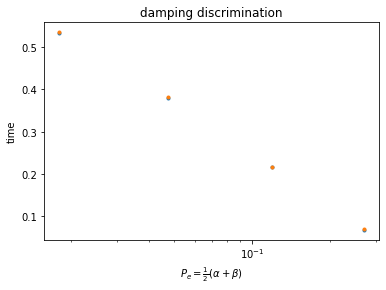

In [384]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in boundsB]
times_alpha_to_errB = [timind[np.argmin(np.abs(alpha[indb,:] - errs[indb]))] for indb in range(len(boundsB))]

ax = plt.subplot(111)
plt.title("{} discrimination".format(mode))
lin=6
ax.plot([avg_err_alpha(b) for b in boundsB],stopping_0, '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot([avg_err_alpha(b) for b in boundsB],stopping_1, '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)

ax.set_xscale("log")
ax.set_ylabel("time")
ax.set_xlabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')


In [385]:
def ggiulio_prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1):
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    S= np.sqrt(2*mu)

    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div

def drift(kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1):
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    return mu 

In [386]:
pars = give_def_params_discrimination(flip=1, mode = "damping")
params, exp_path = check_params(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

mu0 = drift(kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)

pars = give_def_params_discrimination(flip=0, mode = "damping")
params, exp_path = check_params(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

mu1 = drift(kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)
errs = [avg_err_alpha(b) for b in boundsB]
times_alpha_to_errB = [timind[np.argmin(np.abs(alpha[indb,:] - errs[indb]))] for indb in range(len(boundsB))]

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


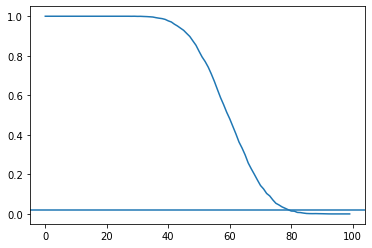

In [387]:
times_alpha_to_errB = [timind[np.argmin(np.abs(alpha[indb,:] - errs[indb]))] for indb in range(len(boundsB))]
indb = 4
ax=plt.subplot(111)
ax.plot(alpha[indb,:])
ax.axhline(avg_err_alpha(boundsB[4]))

In [388]:
times_alpha_to_errB = [timind[np.argmin(np.abs(alpha[indb,:] - errs[indb]))] for indb in range(len(boundsB))]

In [389]:
times_alpha_to_errB/stopping_0

array([50.        ,  4.56424575,  3.71305212,  3.90099309,  4.1584142 ])

Text(0, 0.5, 'deterministic/stochastic')

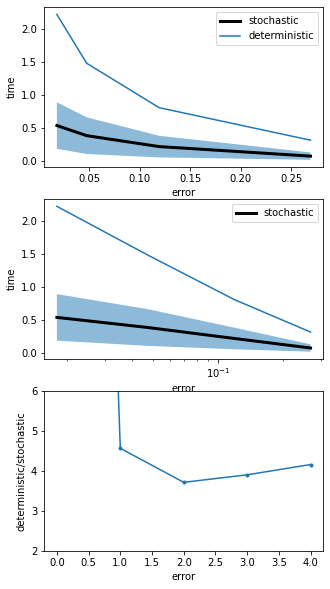

In [390]:
plt.figure(figsize=(5,10))

ax = plt.subplot(311)
k=8
boundsplot = boundsB

ax.plot(errs, stopping_1, color="black", linewidth=3, label="stochastic")
ax.fill_between(errs, stopping_1 - std_stopping_1, stopping_1 + std_stopping_1, alpha=0.5)
#for indb, b in enumerate(boundsplot):
    
ax.plot(errs,times_alpha_to_errB , label="deterministic")
#ax.set_xscale("log")
ax.legend()
ax.set_xlabel("error")
ax.set_ylabel("time")



ax = plt.subplot(312)
k=8
boundsplot = boundsB

ax.plot(errs, stopping_1, color="black", linewidth=3, label="stochastic")
ax.fill_between(errs, stopping_1 - std_stopping_1, stopping_1 + std_stopping_1, alpha=0.5)
ax.plot(errs,times_alpha_to_errB)

ax.set_xscale("log")
ax.legend()
ax.set_xlabel("error")
ax.set_ylabel("time")


ax = plt.subplot(313)
ax.plot(times_alpha_to_errB/stopping_0, '.-')
ax.set_yticks(np.arange(0,11,1))
ax.set_ylim([2,6])
ax.set_xlabel("error")
ax.set_ylabel("deterministic/stochastic")

In [583]:
pars = give_def_params_discrimination(flip=0, mode = "damping")
params, exp_path = check_params(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
mu1 = drift(kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)

gp1 = [ggiulio_prob(t, boundsB[-1], kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1) for t in timind]

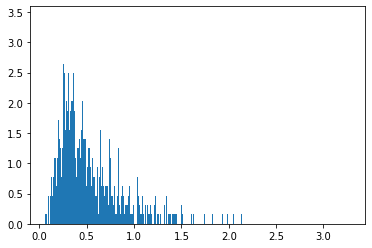

In [584]:
counts, bins, bars = plt.hist(stop1[:,-1], bins=int(len(stop1)/2), density=True)
times_histogram = 0.5*(bins[1:] + bins[:-1])-bins[0]


In [ ]:
np.

Text(0, 0.5, 'Stopping time probability')

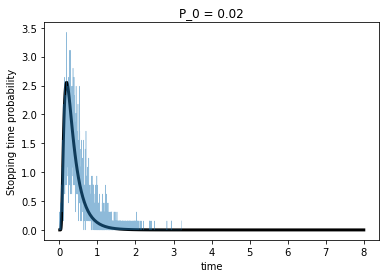

In [560]:
plt.title("P_0 = {}".format(np.round(errs[-1],2)))
plt.plot(timind,gp1, linewidth=3, color="black")
plt.plot(times_histogram, counts, linewidth=0.5, alpha=0.5)
plt.xlabel("time")
plt.ylabel("Stopping time probability")

In [589]:
binsize = bins[1]-bins[0]
np.sum(counts*bins[1:])*binsize

0.5355756221752522

In [610]:
(boundsB[-1]/mu0)/stopping_0[-1]

0.6945454971138855

In [624]:
std/std_stopping_1[-1]

0.5818184927577108

In [606]:
(boundsB[-1]/mu0)**2

0.13721154920350465

In [637]:
b=4.
sigg = b*(1+b)/(mu1**2)
std = np.sqrt(sigg - (boundsB[-1]/mu1)**2)
std, std_stopping_1[-1]

(0.18934735229079583, 0.35245065239211615)

In [638]:
alph = np.array([0.5*(1 + erf(np.sqrt(mu1*t)/(2))) for t in timind])

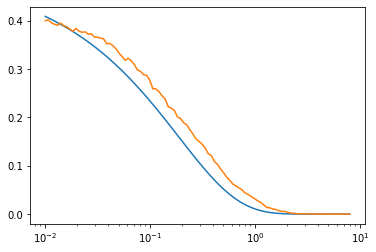

In [640]:
ax=plt.subplot(111)
ax.plot(timind,1-alph)
ax.plot(timind, alpha[0,:])
ax.set_xscale("log")

In [558]:
np.mean(stop1[:,-1])

0.5349343668733747

In [569]:
b = boundsB[-1]

In [573]:
b*np.exp(-b)/mu1

0.006936035458192301

In [582]:
np.mean(stop1[:,-1])

0.5349343668733747

0.3704207731803181

In [472]:
np.sum(counts*np.linspace(0,max(times),len(counts)))/np.sum(counts)

1.1699547471994403

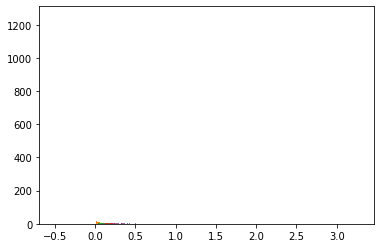

In [518]:
avg_sto1 = np.zeros((len(boundsB)))
for indb, b in enumerate(boundsB):
    counts, bins, bars = plt.hist(stop1[:,indb], bins=int(len(stop1)/4), density=True)
    avg_sto1[indb] = np.sum(counts*np.linspace(0,max(times), len(counts))*binsize)

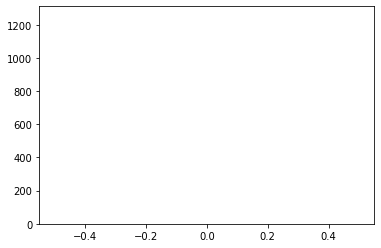

In [521]:
counts, bins, bars = plt.hist(stop1[:,0], bins=int(len(stop1)/4), density=True)


In [ ]:
plt.hist(stop1[:,1], bins=int(len(times)/10))

In [373]:
ep = lambda b: np.exp(-b)/(1 + np.exp(-b))

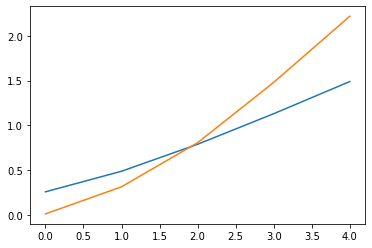

In [376]:
plt.plot(boundsB,-4*np.log(ep(boundsB))/mu)
plt.plot(boundsB, times_alpha_to_errB)

Text(0, 0.5, 'time')

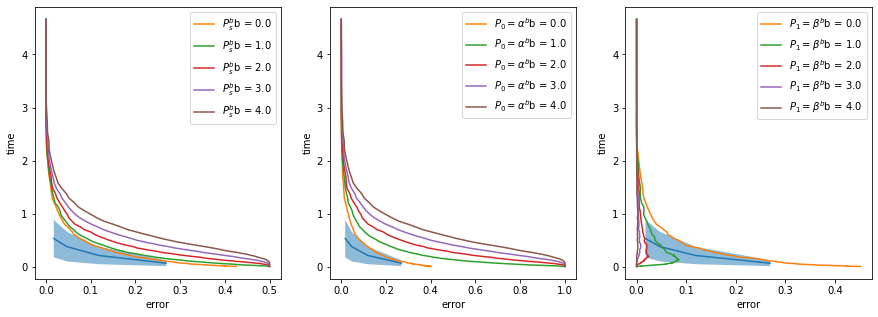

In [306]:

ax = plt.subplot(133)
k=8
ax.plot(errs, stopping_1)
ax.fill_between(errs, stopping_1 - std_stopping_1, stopping_1 + std_stopping_1, alpha=0.5)
for indb, b in enumerate(boundsplot):
    ax.plot(beta[indb,:][:-k], timind[:-k], label=r'$P_1 = \beta^{b}$'+"b = {}".format(np.round(b,2)))
#ax.set_xscale("log")
ax.legend()
ax.set_xlabel("error")
ax.set_ylabel("time")

In [201]:
beta[-1,:]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9974587 , 0.99618806, 0.99237611, 0.98221093, 0.97712834,
       0.94027954, 0.89580686, 0.83989835, 0.75730623, 0.65819568,
       0.52858958, 0.41296061, 0.30622618, 0.19440915, 0.12833545,
       0.08259212, 0.03939009, 0.01778907, 0.00635324, 0.0025413 ,
       0.0025413 , 0.00127065, 0.00127065, 0.00127065, 0.        ])

In [202]:
alpha[-1,:]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9974587 , 0.99618806, 0.99237611, 0.98221093, 0.97712834,
       0.94027954, 0.89580686, 0.83989835, 0.75730623, 0.65819568,
       0.52858958, 0.41296061, 0.30622618, 0.19440915, 0.12833545,
       0.08259212, 0.03939009, 0.01778907, 0.00635324, 0.0025413 ,
       0.0025413 , 0.00127065, 0.00127065, 0.00127065, 0.        ])

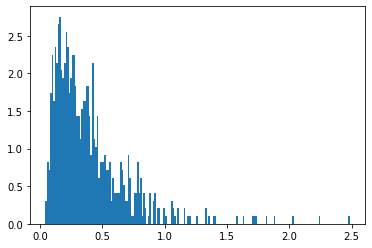

In [140]:
ii = 3
lastt = [stopps0[k][ii] for k in range(len(stopps0))]
counts, bins, bars = plt.hist(lastt, bins=int(len(lastt)/4), density= True)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
gp1 = [ggiulio_prob(t, boundsB[ii], kappa0, kappa1, eta0, eta1, n0, n1, gamma0,gamma1) for t in timind]

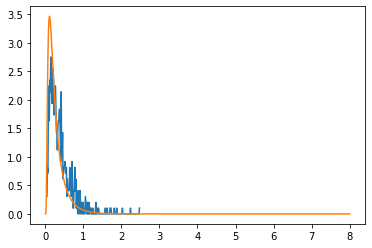

In [141]:
plt.plot(0.5*(bins[1:]+bins[:-1]), counts)
plt.plot(timind, gp1)

In [143]:
np.sum(lastt)/len(lastt)

0.38821527816845625

In [145]:
np.mean(lastt)

0.38821527816845625

0.28402102843619376

In [147]:
np.mean(counts)

0.4094501085042787

In [113]:
np.mean(counts)

0.3903657727290472

In [108]:
boundsB[4]/mu

0.37869470458159166

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


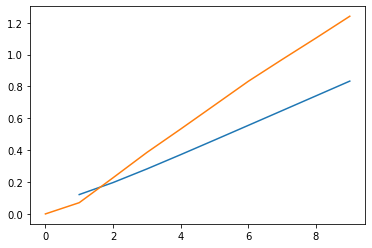

In [43]:
plt.plot(np.abs(np.log(np.array([avg_err_alpha(b) for b in boundsB])))/mu)
plt.plot(0.5*(stop_time0 + stop_time1))

In [ ]:
ax = plt.subplot(111)
ax.plot(alpha[-1,:],timind,'.')
ax.plot([avg_err_alpha(b) for b in boundsB],[times[int(np.argmin(np.abs(times - ss)))] for ss in stop_time0])
ax.plot([avg_err_alpha(b) for b in boundsB],4*np.array([times[int(np.argmin(np.abs(times - ss)))] for ss in stop_time0]))

ax.set_xscale("log")

In [26]:
times_det_alpha_is_b = np.zeros((alpha.shape[0], len(boundsB)))
for contour, bo in enumerate(range(alpha.shape[0])):
    times_det_alpha_is_b[contour] = [times[int(i)] for i in indis_alpha_is_b[contour]]

In [90]:
timind = [times[ind] for ind in indis]

In [89]:
#plt.plot(timind, [avg_err_alpha(b) for b in boundsB])
plt.plot(timind, alpha[0,:])
plt.plot(stop_time0, [avg_err_alpha(b) for b in boundsB])

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


Error in callback <function flush_figures at 0x2afd67df4840> (for post_execute):


KeyboardInterrupt: 

In [35]:
indis_alpha_is_b[-1,:]

array([ 0., 45., 45., 45., 45., 45., 45., 46., 46., 46., 46., 46., 46.,
       47., 47., 47., 47., 47., 47., 47., 47., 48., 48., 48., 48., 48.,
       48., 48., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49., 49.,
       49., 49., 49., 49., 49., 49., 49., 49., 49.])

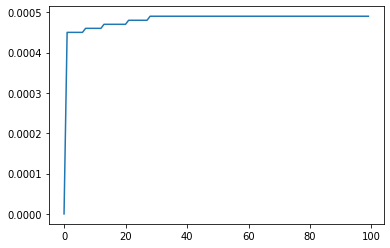

In [29]:
plt.plot(times_det_alpha_is_b[-1])
#plt.plot(stop_time0)

In [ ]:
for itraj in tqdm(range(2,3000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
        stop["h0/h1"][itraj] = []
        stop["h1/h0"][itraj] = []
        ll += log_lik_ratio
        ll0+= log_lik_ratio_swap
        n+=1
        for ind, time_index in enumerate(indis):
            h0_deter = log_lik_ratio[time_index] <= 0
            h1_deter = log_lik_ratio_swap[time_index] <= 0
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
            
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
        for b in boundsB:
            stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
            stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))


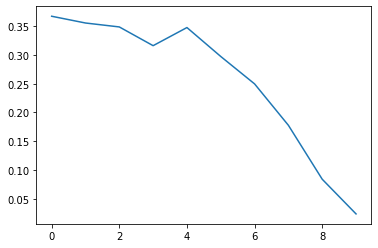

In [24]:
plt.plot(np.array(deter["h1/h0"]))

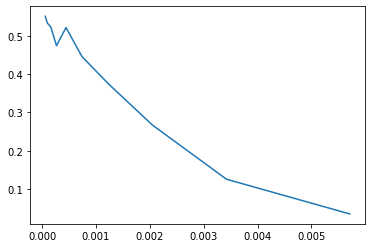

In [21]:
plt.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]))

NameError: name 'ind_max_traj' is not defined

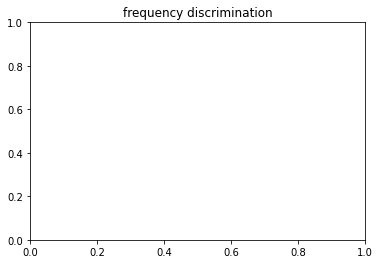

In [120]:
ax = plt.subplot(111)
plt.title("frequency discrimination")
lin=6
ax.plot(stop_time1, [avg_err_alpha(b) for b in boundsB[:len(stopps1[ind_max_traj])]], '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot(stop_time0, [avg_err_alpha(b) for b in boundsB[:len(stopps0[ind_max_traj])]], '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)
ax.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),color="black", label="deterministic")
ax.scatter([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]), color="black")

ax.set_xlabel("time")
ax.set_ylabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')
ax.legend(prop={"size":15})

In [471]:
ll *= len(stop["h0/h1"])**2
ll0 *= len(stop["h0/h1"])**2

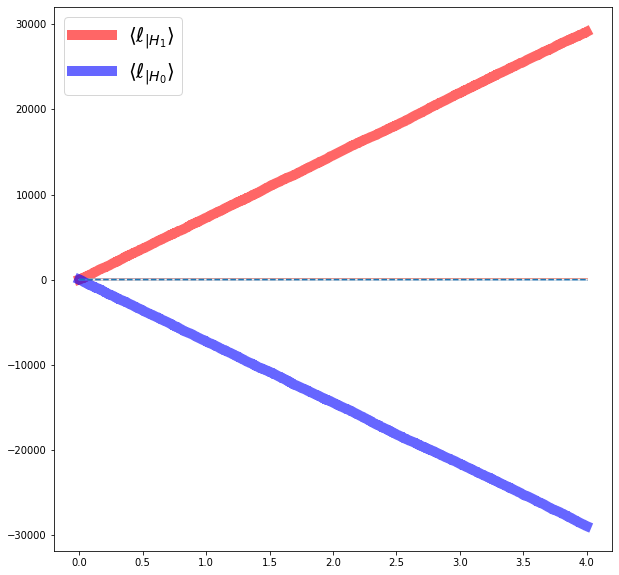

In [14]:

colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")

plt.figure(figsize=(10,10))
alphaMean=0.6
plt.plot(times, ll[:-1],linewidth=10, alpha=alphaMean,  color="red", label=r'$\langle \ell_{|H_1}\rangle$')
Ntraj = 10
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]
             
for ii, itraj in enumerate(range(1,Ntraj)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
    plt.plot(times,log_lik_ratio[:-1], c=c1[ii], alpha=0.75)
    plt.plot(times, log_lik_ratio_swap[:-1],c=c0[ii], alpha=0.75)
plt.plot(times,ll0[:-1], linewidth=10, alpha=alphaMean, color="blue", label=r'$\langle \ell_{|H_0}\rangle$')
plt.plot(times, np.zeros(len(ll0)-1),"--")

plt.legend(prop={"size":20})

In [476]:
import os 
freq_dir = get_def_path(mode="continuous")+"freq_discrimination/"
os.makedirs(freq_dir, exist_ok=True)

np.save(freq_dir+"mean_likelihood_0", ll0)
np.save(freq_dir+"mean_likelihood_1", ll)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time1",stop_time1)
np.save(freq_dir+"stop_time0",stop_time0)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))